# Getting the data ready

## Parse the text

In [1]:
import re
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

class MedicalAbstractDataset(Dataset):
    def __init__(self, file_path, tokenizer, label_map, max_length=512):
        self.examples = []
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_length = max_length

        with open(file_path, 'r') as file:
            current_id = None
            for line in file:
                line = line.strip()
                if line.startswith("###"):  # New document ID
                    current_id = line
                elif re.match(r'^[A-Z]+', line.split("\t")[0]):
                    # Split line to get label and text
                    section = line.split("\t")
                    label = section[0]
                    text = section[1]

                    if label in self.label_map:
                        self.examples.append((current_id, label, text))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        _, label, text = self.examples[idx]
        label_id = self.label_map[label]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label_id, dtype=torch.long)
        }

## Create output label mappings (classes)

In [2]:
label_map = {
    'BACKGROUND': 0,
    'OBJECTIVE': 1,
    'METHODS': 2,
    'RESULTS': 3,
    'CONCLUSIONS': 4
}

## Build BERT tokenizer

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Create torch dataloaders

In [4]:
!wget "https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/refs/heads/master/PubMed_20k_RCT/train.txt"
!wget "https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/refs/heads/master/PubMed_20k_RCT/test.txt"

--2024-11-01 15:23:30--  https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/refs/heads/master/PubMed_20k_RCT/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29384101 (28M) [text/plain]
Saving to: ‘train.txt.2’

train.txt.2         100%[===================>]  28.02M  --.-KB/s    in 0.07s   

2024-11-01 15:23:30 (416 MB/s) - ‘train.txt.2’ saved [29384101/29384101]

--2024-11-01 15:23:30--  https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/refs/heads/master/PubMed_20k_RCT/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awai

In [5]:
import torch
import os
root_dir = os.getcwd()
train_dir = root_dir + "/train.txt"
test_dir = root_dir + "/test.txt"
cpu_count = os.cpu_count()
BATCH_SIZE = 128
NUM_WORKERS = cpu_count
MAX_LENGTH = 256

train_data = MedicalAbstractDataset(train_dir, tokenizer, label_map, max_length=MAX_LENGTH)
test_data = MedicalAbstractDataset(test_dir, tokenizer, label_map, max_length=MAX_LENGTH)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7adc49c29f00>,
 <torch.utils.data.dataloader.DataLoader at 0x7adc49c2a020>)

In [6]:
### Verify the train dataloader
for batch in train_dataloader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']

    print("Input IDs shape:", input_ids.shape)
    print("Attention mask shape:", attention_mask.shape)
    print("Labels shape:", labels.shape)

    break

Input IDs shape: torch.Size([128, 256])
Attention mask shape: torch.Size([128, 256])
Labels shape: torch.Size([128])


In [7]:
### Verify the test dataloader
for batch in test_dataloader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']

    print("Input IDs shape:", input_ids.shape)
    print("Attention mask shape:", attention_mask.shape)
    print("Labels shape:", labels.shape)

    break

Input IDs shape: torch.Size([128, 256])
Attention mask shape: torch.Size([128, 256])
Labels shape: torch.Size([128])


# Modelling

## Getting the model ready

In [8]:
from transformers import BertForSequenceClassification
num_classes = len(label_map) # 5
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu" # | Run this for nvidia GPU
#device = "mps" if torch.backends.mps.is_available() else "cpu" # | Run this for mac
device = torch.device(device)
bert_model.to(device)

bert_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training

In [9]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5, weight_decay=0.01)
loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 1e-05
     maximize: False
     weight_decay: 0.01
 ))

In [10]:
device

device(type='cuda')

In [13]:
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
scaler = GradScaler()
def train_bert(model,
               train_dataloader,
               test_dataloader,
               loss_fn,
               optimizer,
               epochs,
               device,
               print_freq=10):
    results = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_samples = 0

        for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():  # Enable mixed precision
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

            optimizer.zero_grad()
            scaler.scale(loss).backward()  # Scale the loss
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_samples += labels.size(0)

            if (step + 1) % print_freq == 0:
                avg_loss = train_loss / (step + 1)
                accuracy = train_correct / train_samples
                print(f"Step [{step + 1}/{len(train_dataloader)}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        avg_train_loss = train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_samples
        results["train_loss"].append(avg_train_loss)
        results["train_accuracy"].append(train_accuracy)

        # Evaluation phase (similar adjustments for mixed precision)
        model.eval()
        test_loss = 0
        test_correct = 0
        test_samples = 0
        with torch.no_grad():
            for batch in test_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                with autocast():
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    logits = outputs.logits

                test_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                test_correct += (preds == labels).sum().item()
                test_samples += labels.size(0)

        avg_test_loss = test_loss / len(test_dataloader)
        test_accuracy = test_correct / test_samples
        results["test_loss"].append(avg_test_loss)
        results["test_accuracy"].append(test_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return results


<ipython-input-13-e296d92f8049>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [14]:
### Training the model
EPOCHS = 1

results = train_bert(
    model = bert_model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = EPOCHS,
    device = device,
    print_freq = 100
)

Epoch 1/1:   0%|          | 0/1407 [00:00<?, ?it/s]

<ipython-input-13-e296d92f8049>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step [100/1407], Loss: 1.0833, Accuracy: 0.6156
Step [200/1407], Loss: 0.8648, Accuracy: 0.6968
Step [300/1407], Loss: 0.7599, Accuracy: 0.7359
Step [400/1407], Loss: 0.6936, Accuracy: 0.7589
Step [500/1407], Loss: 0.6493, Accuracy: 0.7743
Step [600/1407], Loss: 0.6154, Accuracy: 0.7862
Step [700/1407], Loss: 0.5911, Accuracy: 0.7944
Step [800/1407], Loss: 0.5728, Accuracy: 0.8005
Step [900/1407], Loss: 0.5575, Accuracy: 0.8053
Step [1000/1407], Loss: 0.5446, Accuracy: 0.8095
Step [1100/1407], Loss: 0.5334, Accuracy: 0.8131
Step [1200/1407], Loss: 0.5242, Accuracy: 0.8160
Step [1300/1407], Loss: 0.5156, Accuracy: 0.8187
Step [1400/1407], Loss: 0.5082, Accuracy: 0.8209


<ipython-input-13-e296d92f8049>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/1] - Train Loss: 0.5076, Train Accuracy: 0.8211, Test Loss: 0.4177, Test Accuracy: 0.8490


In [16]:
### Save the model
save_path = root_dir + "/bert_fine_tune_1.pth"
torch.save(bert_model.state_dict(), save_path)
print(f"Model state dictionary saved to {save_path}")

Model state dictionary saved to /content/bert_fine_tune_1.pth


In [18]:
itos = {
    0: 'BACKGROUND',
    1: 'OBJECTIVE',
    2: 'METHODS',
    3: 'RESULTS',
    4: 'CONCLUSIONS'
}
bert_model.to(device)

def predict_sample(text, model, tokenizer, label_map):
    # Preprocess the input text
    encoding = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    # Move tensors to the appropriate device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Forward pass (no gradients needed for inference)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get the predicted label
    predicted_class = torch.argmax(logits, dim=1).item()
    predicted_label = itos[predicted_class]

    return predicted_label

# Sample input text
sample_text = "This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure."
predicted_label = predict_sample(sample_text, bert_model, tokenizer, label_map)
print(f"Predicted label: {predicted_label}")

Predicted label: OBJECTIVE


In [31]:
results

{'train_loss': [0.507557946100418],
 'train_accuracy': [0.8211064207953788],
 'test_loss': [0.41773838335174623],
 'test_accuracy': [0.8490459598473535]}

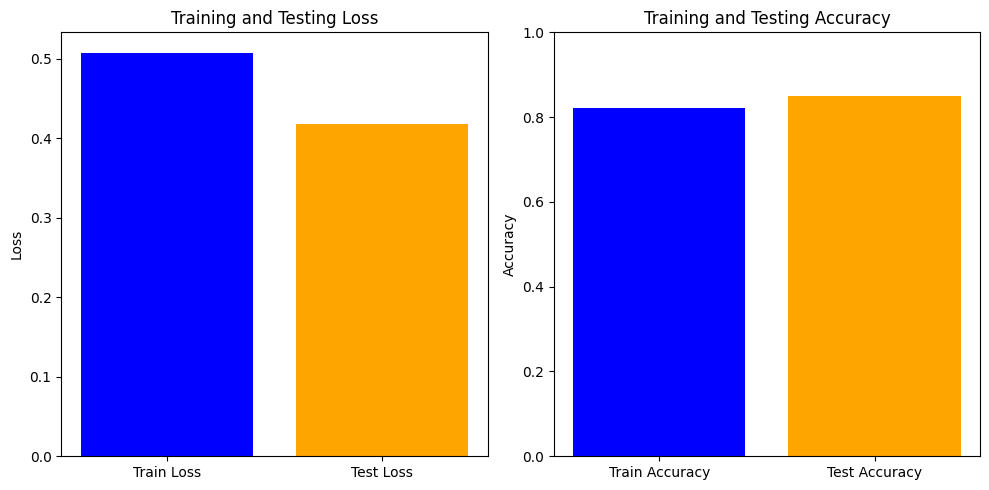

In [39]:
import matplotlib.pyplot as plt

train_loss = results['train_loss'][0]
train_accuracy = results['train_accuracy'][0]
test_loss = results['test_loss'][0]
test_accuracy = results['test_accuracy'][0]

# Data
loss_metrics = ['Train Loss', 'Test Loss']
loss_values = [train_loss, test_loss]
accuracy_metrics = ['Train Accuracy', 'Test Accuracy']
accuracy_values = [train_accuracy, test_accuracy]

# Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(loss_metrics, loss_values, color=['blue', 'orange'])
plt.ylabel('Loss')
plt.title('Training and Testing Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.bar(accuracy_metrics, accuracy_values, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')

plt.tight_layout()
plt.show()

## Untrained model vs Trained model
Comparision for the sake of fine-tuning (checking if fine-tuning the model acctually helped)

In [41]:
### Creating the model
from transformers import BertConfig, BertForSequenceClassification
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_classes)
untrained_model = BertForSequenceClassification(config)
untrained_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [42]:
def evaluate_model(model,
                   dataloader,
                   loss_fn,
                   device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

# Eval both the models
trained_test_loss, trained_test_accuracy = results['test_loss'][0], results['test_accuracy'][0] # Eval already done
untrained_test_loss, untrained_test_accuracy = evaluate_model(
    untrained_model,
    test_dataloader,
    loss_fn,
    device
)

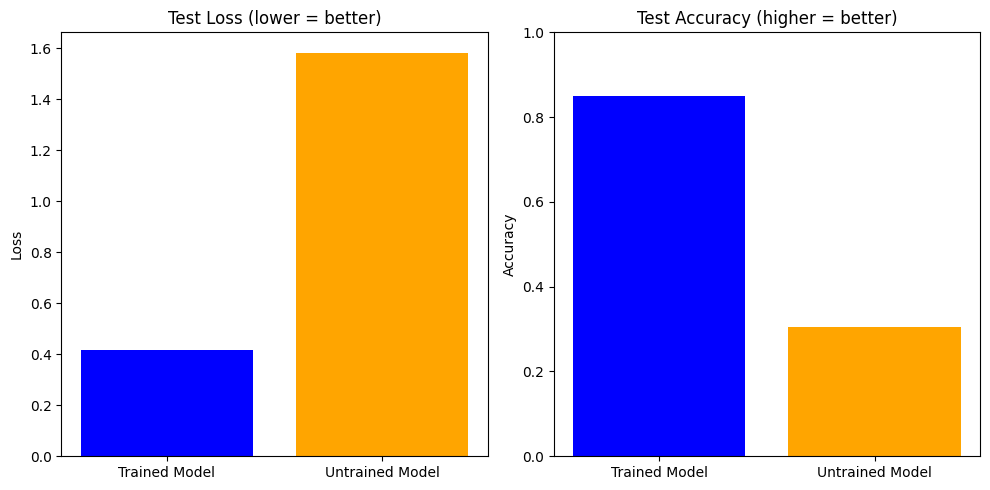

<Figure size 640x480 with 0 Axes>

In [46]:
### Plots to compare the models
loss_metrics = ['Trained Model', 'Untrained Model']
loss_values = [trained_test_loss, untrained_test_loss]
accuracy_metrics = ['Trained Model', 'Untrained Model']
accuracy_values = [trained_test_accuracy, untrained_test_accuracy]

# Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(loss_metrics, loss_values, color=['blue', 'orange'])
plt.ylabel('Loss')
plt.title('Test Loss (lower = better)')

# Accuracy
plt.subplot(1, 2, 2)
plt.bar(accuracy_metrics, accuracy_values, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Test Accuracy (higher = better)')

plt.tight_layout()
plt.show()
plt.savefig(root_dir + "/model_comparision.png")